## Factor Rotation

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pyodbc
import pickle
import os
os.chdir('T:\\index\\95_곽용하\\운용\\코드\\')
import mf_3 as mf
import ipca

# DATABASE
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

In [2]:
open_path = 'T:\\index\\999_quant\\run_kyh\\sector_data\\'
with open(open_path+'past_daily_pbr_cap_adjprc_data.pkl', 'rb') as f:
    df00 = pickle.load(f)

In [3]:
df00.dropna().tail(10)

,TRD_DT,TRD_DT_BASE,STK_CD,FactorGroup_sub,value,MKT_VAL,CLOSE_PRC,AADJ,ADJ_PRC,BV,PBR,FWD_RTN,FWD_RTN_20
7242878,2024-06-10,2024-05-31,A329180,Value,1.0,1.148724e+13,129400.0,1.0,129400.0,5.207435e+12,2.205931,0.002318,0.174652
7242879,2024-06-10,2024-05-31,A336260,Value,1.0,1.476884e+12,22550.0,1.0,22550.0,4.721878e+11,3.127746,0.000000,-0.084257
7242880,2024-06-10,2024-05-31,A352820,Value,1.0,8.434550e+12,202500.0,1.0,202500.0,2.919395e+12,2.889143,-0.022222,-0.030617
7242881,2024-06-10,2024-05-31,A361610,Value,1.0,3.176308e+12,44550.0,1.0,44550.0,2.411658e+12,1.317064,0.035915,-0.005612
7242882,2024-06-10,2024-05-31,A373220,Value,1.0,8.260200e+13,353000.0,1.0,353000.0,2.020062e+13,4.089082,0.009915,0.015581
7242883,2024-06-10,2024-05-31,A375500,Value,4.0,1.338799e+12,34600.0,1.0,34600.0,4.470206e+12,0.299494,-0.011561,-0.088150
7242884,2024-06-10,2024-05-31,A377300,Value,1.0,4.022401e+12,29900.0,1.0,29900.0,1.877122e+12,2.142855,0.023411,-0.088629
7242885,2024-06-10,2024-05-31,A383220,Value,3.0,2.581897e+12,67400.0,1.0,67400.0,1.290514e+12,2.000673,0.013353,-0.120178
7242886,2024-06-10,2024-05-31,A402340,Value,1.0,1.210055e+13,89800.0,1.0,89800.0,1.520182e+13,0.795993,-0.018931,0.146993
7242887,2024-06-10,2024-05-31,A450080,Value,1.0,8.761123e+12,127000.0,1.0,127000.0,7.990962e+11,10.963789,0.037795,-0.205512


#### 아웃라이어 수정

In [4]:
def ajdust_percentile(x):
    q90 = x.quantile(0.90)
    q10 = x.quantile(0.10)
    return np.where(x>q90, q90, np.where(x<q10,q10,x))

df01 = df00.copy()
df01['adj_RTN'] = df01.groupby(['TRD_DT','FactorGroup_sub','value'])['FWD_RTN'].transform(ajdust_percentile)
df01['adj_20_rtn'] = df01.groupby(['TRD_DT','FactorGroup_sub','value'])['FWD_RTN_20'].transform(ajdust_percentile)

#### 시총(제곱근) 가중 계산

In [5]:
df01['sqrt_cap'] = np.sqrt(df01['MKT_VAL'])
df01['cap_fwd_rtn'] = df01.sqrt_cap * df01.adj_RTN
df01['cap_fwd_20d_rtn'] = df01.sqrt_cap * df01.adj_20_rtn

#### Daily Rtn

In [6]:
df03 = df01.dropna()
df03 = df03.groupby(['TRD_DT','FactorGroup_sub','value'])['cap_fwd_rtn'].sum() / df03.groupby(['TRD_DT','FactorGroup_sub','value'])['sqrt_cap'].sum()
df03 = df03.reset_index()
df03.columns = ['TRD_DT','FactorGroup_sub','value','fwd_rtn']
df03_pivot = df03.pivot_table('fwd_rtn','TRD_DT',['FactorGroup_sub','value'],dropna=False)

# 4분위 - 1분위
df03_pivot_scaled_stack = df03_pivot.stack().reset_index()
df03_4q = df03_pivot_scaled_stack[df03_pivot_scaled_stack['value']==4]
df03_1q = df03_pivot_scaled_stack[df03_pivot_scaled_stack['value']==1]

df03_4q.set_index('TRD_DT',inplace=True)
df03_1q.set_index('TRD_DT',inplace=True)

# 4분위, 1분위
df03_4q = df03_4q.iloc[:,1:]
df03_1q = df03_1q.iloc[:,1:]

# 롱숏
df03_ls = df03_4q - df03_1q

In [7]:
with open(open_path+'daily_factor_fwdrtn.pkl', 'wb') as f:
    pickle.dump(df03_ls, f)

<AxesSubplot:xlabel='TRD_DT'>

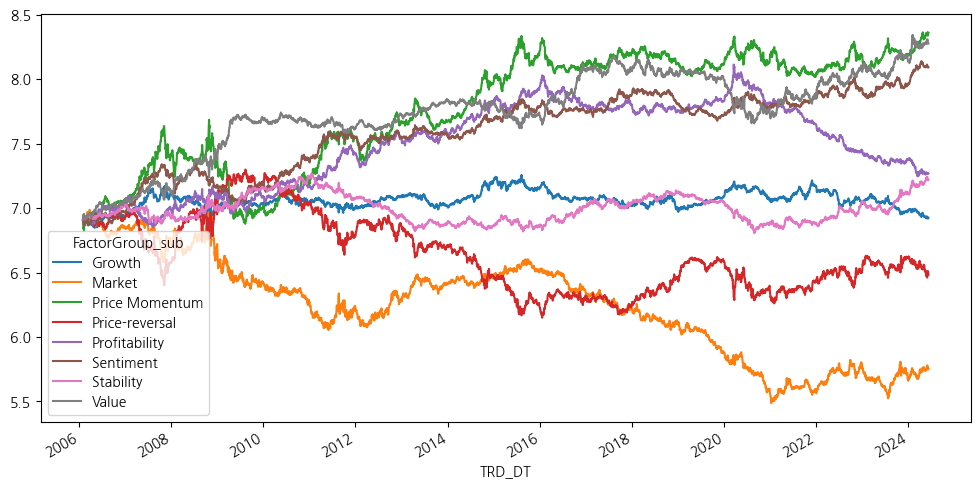

In [8]:
factor_index_history = (1+df03_ls.shift(1)).cumprod()*1000
factor_index_history.fillna(1000,inplace=True)

factor_log_index_history = np.log1p((1+df03_ls.shift(1)).cumprod()*1000)
factor_log_index_history.fillna(np.log1p(1000),inplace=True)
factor_log_index_history.plot(figsize=(12,6))

### 20day Forward Return

In [9]:
df04 = df01.dropna()
df04 = df04.groupby(['TRD_DT','FactorGroup_sub','value'])['cap_fwd_20d_rtn'].sum() / df04.groupby(['TRD_DT','FactorGroup_sub','value'])['sqrt_cap'].sum()
df04 = df04.reset_index()
df04.columns = ['TRD_DT','FactorGroup_sub','value','fwd_20d_rtn']
df04_pivot = df04.pivot_table('fwd_20d_rtn','TRD_DT',['FactorGroup_sub','value'],dropna=False)

# 4분위 - 1분위
df04_pivot_scaled_stack = df04_pivot.stack().reset_index()
df04_4q = df04_pivot_scaled_stack[df04_pivot_scaled_stack['value']==4]
df04_1q = df04_pivot_scaled_stack[df04_pivot_scaled_stack['value']==1]

df04_4q.set_index('TRD_DT',inplace=True)
df04_1q.set_index('TRD_DT',inplace=True)

df04_4q = df04_4q.iloc[:,1:]
df04_1q = df04_1q.iloc[:,1:]

df04_ls = df04_4q - df04_1q

### BM (kospi 200)

In [10]:
sql_bm = '''  SELECT CONVERT(DATE,TRD_DT,112) TRD_DT, CLOSE_PRC as KSP200
                FROM WISEFN..TS_IDX_DAILY
                WHERE SEC_CD = 'IKS200'
                ORDER BY TRD_DT  '''
df_bm = pd.read_sql(sql_bm, conn_wisefn)
df_bm.set_index('TRD_DT',inplace=True)
df_bm.index = pd.to_datetime(df_bm.index)
df_bm_fwd_rtn = df_bm.pct_change(1).shift(-1)

C:\Users\11149\AppData\Local\Temp\ipykernel_23460\948290215.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_bm = pd.read_sql(sql_bm, conn_wisefn)


### Macro Data

In [11]:
path_daily = 'T:\\index\\999_quant\\__data_pkl\\kgh\\tmp_daily\\'
with open(path_daily +'economy_all.pkl', 'rb') as f:
    econ = pickle.load(f) #76개의 데이터 종류

In [12]:
econ_pick = econ[['bnd_10y', 'bnd_1y', 'bnd_20y','bnd_3y','bnd_5y','cbnd_3y','cbnd_3y_jnk','cd_91d', #금리
                    'usd','euro','yen', #통화
                    ]] #경제성장

In [13]:
# 변화율
econ_pick_chg = econ_pick.pct_change(1).dropna()
econ_pick_chg = econ_pick_chg.reset_index().rename(columns={'date':'TRD_DT'})
econ_pick_chg['TRD_DT'] = pd.to_datetime(econ_pick_chg['TRD_DT'])
econ_pick_chg = econ_pick_chg[econ_pick_chg['TRD_DT'].isin(df04_ls.index)].reset_index(drop=True).set_index('TRD_DT')
econ_pick_chg.head(10)

code,bnd_10y,bnd_1y,bnd_20y,bnd_3y,bnd_5y,cbnd_3y,cbnd_3y_jnk,cd_91d,usd,euro,yen
TRD_DT,,,,,,,,,,,
2006-01-31,-0.001835,0.000000,-0.001739,-0.002028,-0.001934,0.000000,-0.001106,0.004808,0.003306,-0.006719,-0.007949
2006-02-01,-0.011029,0.000000,-0.012195,-0.006098,-0.011628,-0.007380,-0.007752,0.004785,-0.002472,0.002028,0.000764
2006-02-02,0.001859,0.000000,0.001764,0.002045,0.001961,0.001859,-0.001116,0.002381,-0.007743,-0.014564,-0.013966
2006-02-03,0.007421,0.004348,0.007042,0.010204,0.009785,0.005566,0.005587,0.002375,0.008948,0.011208,0.004865
2006-02-06,-0.005525,0.000000,-0.005245,-0.004040,-0.005814,-0.003690,-0.004444,0.004739,0.000928,-0.003549,-0.001308
2006-02-07,0.003704,0.002165,0.003515,0.004057,0.003899,0.003704,0.002232,0.002358,-0.004224,-0.009265,-0.006096
2006-02-08,0.000000,0.000000,0.000000,0.000000,-0.001942,0.000000,-0.002227,0.002353,0.001345,0.002766,0.012870
2006-02-09,-0.025830,-0.012959,-0.024518,-0.020202,-0.023346,-0.018450,-0.015625,0.000000,0.002273,-0.000155,-0.005046
2006-02-10,-0.001894,0.000000,-0.001795,0.000000,0.000000,0.000000,-0.001134,0.000000,0.001237,0.003664,-0.000611


### IPCA: Instrumented PCA

In [ ]:
test_ipca = ipca.InstrumentedPCA(n_factors=4, intercept=False)
test_ipca.fit()

### Cyclical features

#### Seasonal Features

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf


<AxesSubplot:xlabel='TRD_DT'>

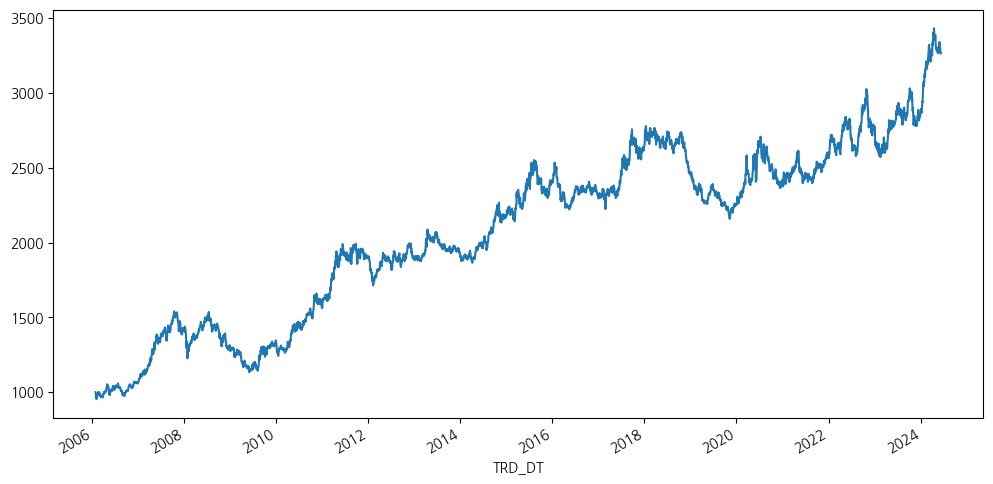

In [21]:
(factor_index_history['Sentiment'].fillna(1000)).plot(figsize=(12,6))

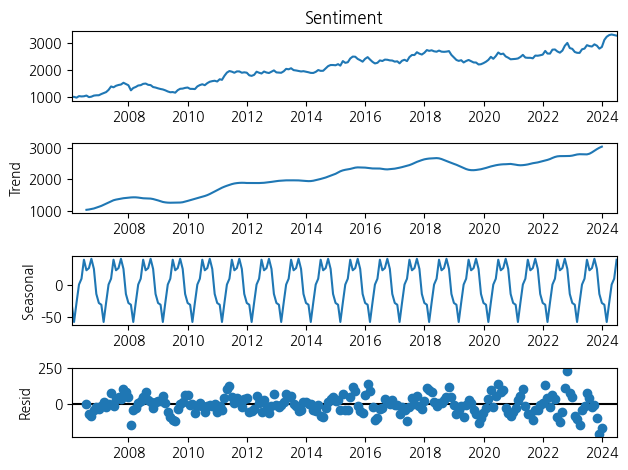

In [22]:
# 월간 데이터로 바꾸기
monthly_factor_index = factor_index_history.resample('M').last().fillna(1000)
ts_sentiment = pd.Series(monthly_factor_index['Sentiment'])
result = seasonal_decompose(ts_sentiment, model='additive',period=12)
result.plot()
plt.show()

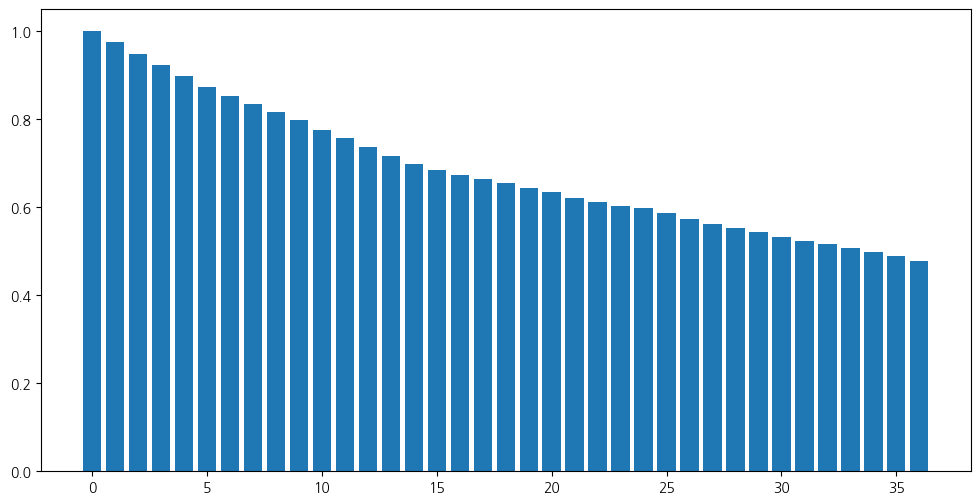

In [23]:
# ACF
acf_values = acf(ts_sentiment, nlags=36)
plt.figure(figsize=(12,6))
plt.bar(range(len(acf_values)),acf_values)
plt.show()

In [24]:
df_rsi = mf.RSI(df03_ls,60).dropna()

<AxesSubplot:xlabel='TRD_DT'>

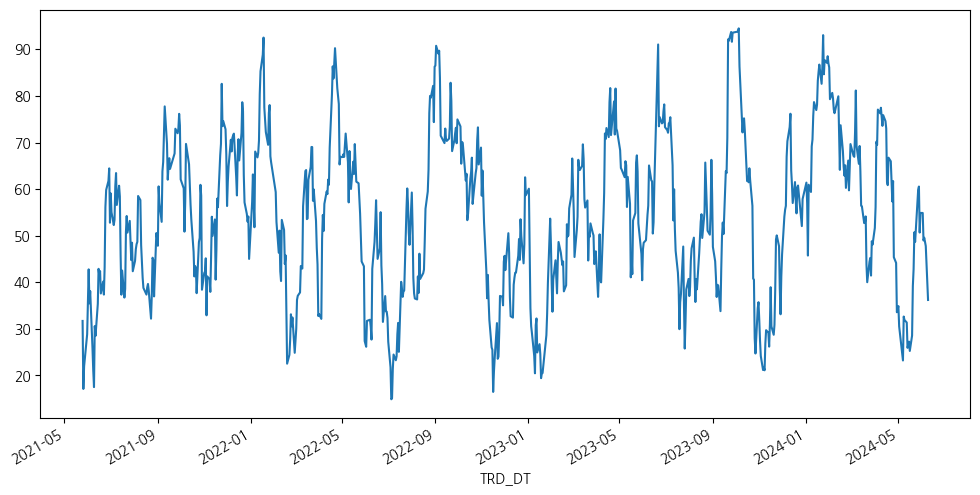

In [25]:
df_rsi['Sentiment'][-750:].plot(figsize=(12,6))